## Initial exploratory analysis and generation of a baseline model

### 1) Data cleaning and pre-processing

In [1]:
# import packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import gc

In [2]:
# load data (train.csv will be the complete dataset for predictive modeling, ignore Test.csv for now)
data=pd.read_csv("./data/Train.csv")

#### Convert the sensor data for each feature from string type into a list of values

In [3]:
# define a function to replace spaces in the string (i.e. missings) with NaN
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)

# define list of feature names
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]


for feature in features : 
    # first replace every 'nan' in a cell with an empty space, split using comma, and then apply replace_nan function on every item
    data[feature]=data[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])    

### Features engineering

#### calculate percent NaN for each recording period per feature

In [4]:
# recording periods contain varying degrees of NaNs: compute percent NaN for each recording period and feature
# function to compute the percentage of NaNs per recording period
def compute_percent_nan(df, col_name):
    df['percent_nan_'+col_name] = df[col_name].apply(lambda x: np.isnan(np.array(x)).sum()/len(x)*100)
    return df

In [5]:
# calculate percentage of missings per recording period and feature and append to dataframe
for col_name in tqdm(features):
    data=compute_percent_nan(data,col_name)

100%|██████████| 6/6 [00:00<00:00, 10.90it/s]


#### Remove NaNs from lists of raw data and extract summary statistics

In [6]:
# aggregation function extracting summary statistics from every recording period and appending it as a new column to a dataframe
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  

# function returning only non-Null values (helper for aggregation function)
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]


In [7]:
# remove NaNs from dataframe
for col_name in tqdm(features):
   data[col_name]=data[col_name].apply(remove_nan_values)

100%|██████████| 6/6 [00:00<00:00,  8.71it/s]


In [8]:
#extract summary statistics for each recording period and feature
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


##### Extract individual raw values from list for each feature and append as separate columns

In [9]:
# extract all single raw values from each feature and append them as new columns to the dataframe
for x in range(121):
    data["newtemp"+ str(x)] = data.temp.str[x]
    data["newprecip"+ str(x)] = data.precip.str[x]
    data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
    data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
    data["windspeed"+ str(x)] = data.wind_spd.str[x]
    data["atmospherepressure"+ str(x)] = data.atmos_press.str[x]

/var/folders/dn/n_6mm8pj72738s4ygylk0sgm0000gn/T/ipykernel_34868/268327596.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
/var/folders/dn/n_6mm8pj72738s4ygylk0sgm0000gn/T/ipykernel_34868/268327596.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
/var/folders/dn/n_6mm8pj72738s4ygylk0sgm0000gn/T/ipykernel_34868/268327596.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

#### drop raw data contained in lists

In [10]:
# drop raw sensor data contained as list from the initial dataset
data.drop(features,1,inplace=True)

/var/folders/dn/n_6mm8pj72738s4ygylk0sgm0000gn/T/ipykernel_34868/1401606462.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(features,1,inplace=True)


In [11]:
data.head()

,ID,location,target,percent_nan_temp,percent_nan_precip,percent_nan_rel_humidity,percent_nan_wind_dir,percent_nan_wind_spd,percent_nan_atmos_press,max_temp,...,newrel_humidity119,newwind_dir119,windspeed119,atmospherepressure119,newtemp120,newprecip120,newrel_humidity120,newwind_dir120,windspeed120,atmospherepressure120
0,ID_train_0,C,45.126304,86.776860,86.776860,86.776860,86.776860,86.776860,86.776860,27.208333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_train_1,D,79.131702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.616667,...,0.649250,73.528733,1.475833,90.439167,21.450000,0.561,0.797333,296.967254,1.019167,90.529167
2,ID_train_10,A,32.661304,0.826446,0.826446,0.826446,38.016529,38.016529,0.826446,31.841667,...,0.437917,NaN,NaN,88.415833,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_train_100,A,53.850238,0.000000,0.000000,0.000000,42.148760,42.148760,0.000000,27.491667,...,0.766417,NaN,NaN,88.490833,24.641667,0.000,0.719667,NaN,NaN,88.465833
4,ID_train_1000,A,177.418750,75.206612,75.206612,75.206612,75.206612,75.206612,75.206612,28.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### select only percent NaN columns and summary statistics

In [12]:
# list dataframe columns for target and condensed features, including percent NaNs
summary_columns = data.columns[:51]
summary_columns

Index(['ID', 'location', 'target', 'percent_nan_temp', 'percent_nan_precip',
       'percent_nan_rel_humidity', 'percent_nan_wind_dir',
       'percent_nan_wind_spd', 'percent_nan_atmos_press', 'max_temp',
       'min_temp', 'mean_temp', 'std_temp', 'var_temp', 'median_temp',
       'ptp_temp', 'max_precip', 'min_precip', 'mean_precip', 'std_precip',
       'var_precip', 'median_precip', 'ptp_precip', 'max_rel_humidity',
       'min_rel_humidity', 'mean_rel_humidity', 'std_rel_humidity',
       'var_rel_humidity', 'median_rel_humidity', 'ptp_rel_humidity',
       'max_wind_dir', 'min_wind_dir', 'mean_wind_dir', 'std_wind_dir',
       'var_wind_dir', 'median_wind_dir', 'ptp_wind_dir', 'max_wind_spd',
       'min_wind_spd', 'mean_wind_spd', 'std_wind_spd', 'var_wind_spd',
       'median_wind_spd', 'ptp_wind_spd', 'max_atmos_press', 'min_atmos_press',
       'mean_atmos_press', 'std_atmos_press', 'var_atmos_press',
       'median_atmos_press', 'ptp_atmos_press'],
      dtype='object')

In [13]:
# select data with summary statistics for the different features
df_condensed = data[summary_columns]
df_condensed.set_index('ID', drop=True, inplace=True)
df_condensed.head()

,location,target,percent_nan_temp,percent_nan_precip,percent_nan_rel_humidity,percent_nan_wind_dir,percent_nan_wind_spd,percent_nan_atmos_press,max_temp,min_temp,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
ID,,,,,,,,,,,,,,,,,,,,,
ID_train_0,C,45.126304,86.776860,86.776860,86.776860,86.776860,86.776860,86.776860,27.208333,19.275000,...,0.155268,0.666250,1.355000,87.871667,87.614167,87.752434,0.070374,0.004952,87.762083,0.257500
ID_train_1,D,79.131702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.616667,17.983333,...,0.290736,0.744167,2.760833,90.725000,90.056667,90.429924,0.156000,0.024336,90.429167,0.668333
ID_train_10,A,32.661304,0.826446,0.826446,0.826446,38.016529,38.016529,0.826446,31.841667,18.458333,...,0.342484,0.942500,2.420000,88.813333,87.982500,88.420931,0.179481,0.032213,88.425000,0.830833
ID_train_100,A,53.850238,0.000000,0.000000,0.000000,42.148760,42.148760,0.000000,27.491667,16.941667,...,0.336701,1.388333,2.469167,88.685000,87.965000,88.376915,0.161758,0.026166,88.400000,0.720000
ID_train_1000,A,177.418750,75.206612,75.206612,75.206612,75.206612,75.206612,75.206612,28.750000,17.525000,...,0.181690,0.542917,1.796667,88.719167,88.268333,88.538104,0.118369,0.014011,88.552500,0.450833


### Filter dataframe for observations with percent NaN < 30% for all features

In [15]:
# get NaN columns
nan_columns = ['percent_nan_temp', 'percent_nan_precip',
       'percent_nan_rel_humidity', 'percent_nan_wind_dir',
       'percent_nan_wind_spd', 'percent_nan_atmos_press']

In [16]:
# filter observations based on percent NaN and check again the data distribution of the target and summary features
df_filtered = df_condensed[(df_condensed[nan_columns]<30).all(axis=1)]
df_filtered.head()

,location,target,percent_nan_temp,percent_nan_precip,percent_nan_rel_humidity,percent_nan_wind_dir,percent_nan_wind_spd,percent_nan_atmos_press,max_temp,min_temp,...,var_wind_spd,median_wind_spd,ptp_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press,ptp_atmos_press
ID,,,,,,,,,,,,,,,,,,,,,
ID_train_1,D,79.131702,0.0,0.0,0.000000,0.000000,0.000000,0.0,33.616667,17.983333,...,0.290736,0.744167,2.760833,90.725000,90.056667,90.429924,0.156000,0.024336,90.429167,0.668333
ID_train_10000,E,17.005000,0.0,0.0,0.000000,14.049587,14.049587,0.0,28.416667,17.183333,...,0.282313,1.075000,3.122500,88.746667,88.097500,88.437645,0.147604,0.021787,88.420833,0.649167
ID_train_10001,C,53.100000,0.0,0.0,0.000000,0.000000,0.000000,0.0,29.266667,19.116667,...,0.198869,0.893333,1.884167,87.961667,87.472500,87.717645,0.121492,0.014760,87.729167,0.489167
ID_train_10002,A,55.051143,0.0,0.0,0.000000,3.305785,3.305785,0.0,29.483333,16.933333,...,0.226285,0.716667,1.919167,88.511667,87.838333,88.212652,0.169373,0.028687,88.235000,0.673333
ID_train_10005,D,55.638261,0.0,0.0,0.826446,1.652893,1.652893,0.0,34.041667,17.191667,...,0.533776,0.840833,3.285000,90.986667,90.211667,90.624814,0.179998,0.032399,90.641667,0.775000


In [17]:
percent_reduc = (df_condensed.shape[0]-df_filtered.shape[0]) / df_condensed.shape[0]*100
print(f'Percent reduction in dataset size after filtering: {round(percent_reduc,1)}%')

Percent reduction in dataset size after filtering: 13.0%


#### log-transform target variable since it is strongly skewed

In [42]:
df_filtered['log_target'] = np.log10(df_filtered.target)

/var/folders/dn/n_6mm8pj72738s4ygylk0sgm0000gn/T/ipykernel_34868/216964214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log_target'] = np.log10(df_filtered.target)


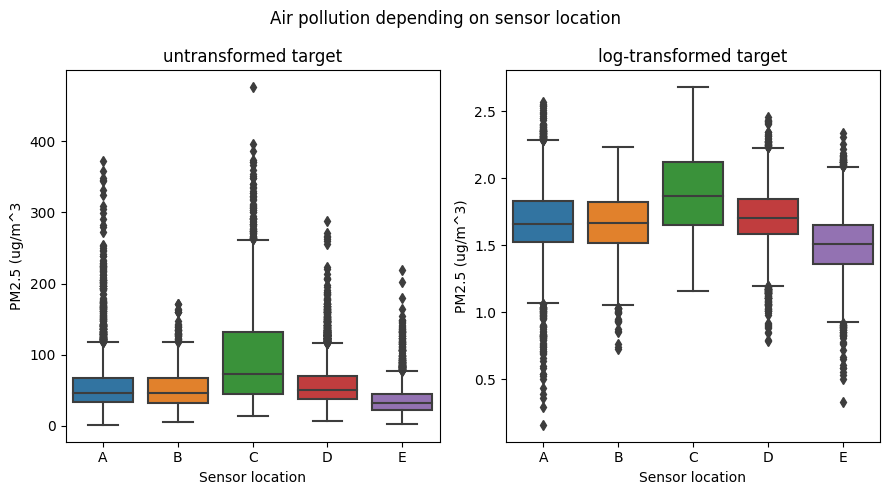

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Air pollution depending on sensor location')

plot1 = sns.boxplot(data=df_filtered, x='location', y='target', ax=ax1, order=['A', 'B', 'C', 'D', 'E'])
ax1.set_title('untransformed target')
ax1.set_ylabel('PM2.5 (ug/m^3')
ax1.set_xlabel('Sensor location')

plot2 = sns.boxplot(data=df_filtered, x='location', y='log_target', ax=ax2, order=['A', 'B', 'C', 'D', 'E'])
ax2.set_title('log-transformed target')
ax2.set_ylabel('PM2.5 (ug/m^3)')
ax2.set_xlabel('Sensor location')

plt.tight_layout();

### Calculate the basemodel using filtered dataset
We compute a baseline model, predicting the target using the mean values of the different features.

In [18]:
# import libraries and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [44]:
# get target and features
X = df_filtered[['location', 'mean_temp', 'mean_precip', 'mean_rel_humidity', 'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press']]
y = df_filtered[['target', 'log_target']]

print(X.shape)
print(y.shape)

(13522, 7)
(13522, 2)


In [45]:
#dummy-encode the location feature
location = pd.get_dummies(X['location'], prefix='location',drop_first=True)
location.head()

,location_B,location_C,location_D,location_E
ID,,,,
ID_train_1,0,0,1,0
ID_train_10000,0,0,0,1
ID_train_10001,0,1,0,0
ID_train_10002,0,0,0,0
ID_train_10005,0,0,1,0


In [46]:
# concatenate dummy-encoded locations feature to original dataframe
X = pd.concat([X, location],axis = 1)
X.head()

,location,mean_temp,mean_precip,mean_rel_humidity,mean_wind_dir,mean_wind_spd,mean_atmos_press,location_B,location_C,location_D,location_E
ID,,,,,,,,,,,
ID_train_1,D,24.679063,0.007025,0.758058,177.109855,0.899208,90.429924,0,0,1,0
ID_train_10000,E,22.581950,0.572736,0.795031,168.296246,1.133221,88.437645,0,0,0,1
ID_train_10001,C,23.638430,0.057628,0.725441,208.343221,0.957961,87.717645,0,1,0,0
ID_train_10002,A,22.624518,0.634215,0.807800,225.092811,0.908583,88.212652,0,0,0,0
ID_train_10005,D,23.189507,0.094843,0.789361,157.660400,1.101989,90.624814,0,0,1,0


In [47]:
# perform train test split, stratified by location in order to ensure that locations are balanced between training and test set
rseed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=X['location'], random_state=rseed)

print(X_train.shape)
print(X_test.shape)

(9465, 11)
(4057, 11)


In [48]:
X_train.columns

Index(['location', 'mean_temp', 'mean_precip', 'mean_rel_humidity',
       'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press', 'location_B',
       'location_C', 'location_D', 'location_E'],
      dtype='object')

In [49]:
# scale features using z-transformation
scaler = StandardScaler()

# fit_transform training data, drop location column since it will not be used for prediction
X_train_scaled = scaler.fit_transform(X_train[['mean_temp', 'mean_precip', 'mean_rel_humidity',
                                                'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press']])
# aply transform to test data
X_test_scaled = scaler.transform(X_test[['mean_temp', 'mean_precip', 'mean_rel_humidity',
                                                'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press']])

In [50]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(9465, 6)
(4057, 6)


In [51]:
# combine scaled metric features and dummy-encoded location features
X_train_preprocessed = np.concatenate([X_train_scaled, X_train[['location_B', 'location_C', 'location_D', 'location_E']]], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test[['location_B', 'location_C', 'location_D', 'location_E']]], axis=1)

print(X_train_preprocessed.shape)
print(X_test_preprocessed.shape)

(9465, 10)
(4057, 10)


#### Train and predict with untransformed target variable

In [52]:
# train the model
linreg = LinearRegression()

linreg.fit(X_train_preprocessed, y_train.target)

LinearRegression()

In [53]:
# get beta coefficients
linreg.coef_

array([ -5.75545372,  -1.71325411,  -5.14513146,   5.31170575,
        -1.1157018 ,   2.87219133,  -2.30083965,  41.52619314,
         2.6077587 , -14.55754424])

In [56]:
# predict new cases
y_pred = linreg.predict(X_test_preprocessed)

# evaluate model accurray

rmse_linreg = mean_squared_error(y_test.target, y_pred, squared=False)
r2_linreg = r2_score(y_test.target, y_pred)

print(f'RMSE on testset: {round(rmse_linreg,2)}')
print(f'Coefficient of determination on testset: {round(r2_linreg,2)}')

RMSE on testset: 39.05
Coefficient of determination on testset: 0.18


#### Train and predict with log-transformed target

In [57]:
# train the model
linreg_log = LinearRegression()

linreg_log.fit(X_train_preprocessed, y_train.log_target)

LinearRegression()

In [58]:
# get beta coefficients
linreg_log.coef_

array([-0.03842835, -0.02844244, -0.03408361,  0.0406856 , -0.00852057,
        0.11069737, -0.05225202,  0.27159146, -0.12742257, -0.12899008])

In [59]:
# predict new cases
y_pred_log = linreg_log.predict(X_test_preprocessed)

# evaluate model accurray

rmse_linreg_log = mean_squared_error(y_test.log_target, y_pred_log, squared=False)
r2_linreg_log = r2_score(y_test.log_target, y_pred_log)

print(f'RMSE on testset: {round(rmse_linreg_log,2)}')
print(f'Coefficient of determination on testset: {round(r2_linreg_log,2)}')

RMSE on testset: 0.24
Coefficient of determination on testset: 0.2


In [78]:
y_pred_log_re = np.power(10, y_pred_log)
y_pred_log_re[:10]

array([47.44057848, 51.42167609, 28.04184375, 45.20031363, 41.05321066,
       55.02971878, 44.8053387 , 39.09746426, 30.59939258, 57.69286031])

In [79]:
# evaluate model accurray with re-transformed y_pred

rmse_linreg_log_re = mean_squared_error(y_test.target, y_pred_log_re, squared=False)
r2_linreg_log_re = r2_score(y_test.target, y_pred_log_re)

print(f'RMSE on testset: {round(rmse_linreg_log_re,2)}')
print(f'Coefficient of determination on testset: {round(r2_linreg_log_re,2)}')

RMSE on testset: 40.39
Coefficient of determination on testset: 0.12


### Residual plot for baseline model trained on filtered data

In [65]:
# calculate residuals
residual = y_test.target - y_pred

# compute mean of residuals
np.mean(residual)

0.34408429897517745

Thus, on average, our baseline model rather seems to underestimate the air pollution, as indicated by an average residual error > 0.

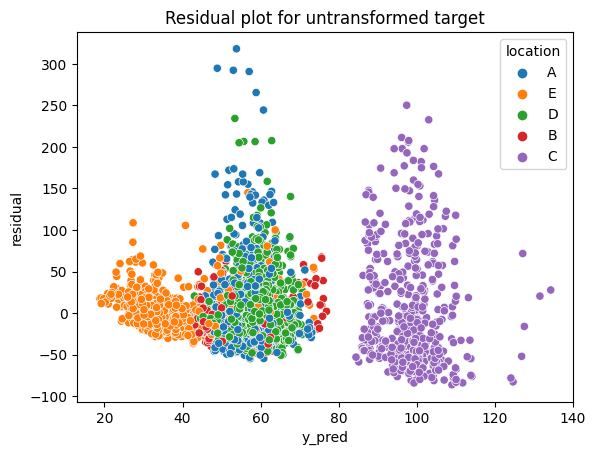

In [66]:
sns.scatterplot(x=y_pred, y=residual, hue=X_test['location'])
plt.xlabel('y_pred')
plt.ylabel('residual')
plt.title('Residual plot for untransformed target');

In [63]:
# calculate residuals for log_transformed target
residual_log = y_test.log_target - y_pred_log

# compute mean of residuals
np.mean(residual_log)

0.0025337516419754766

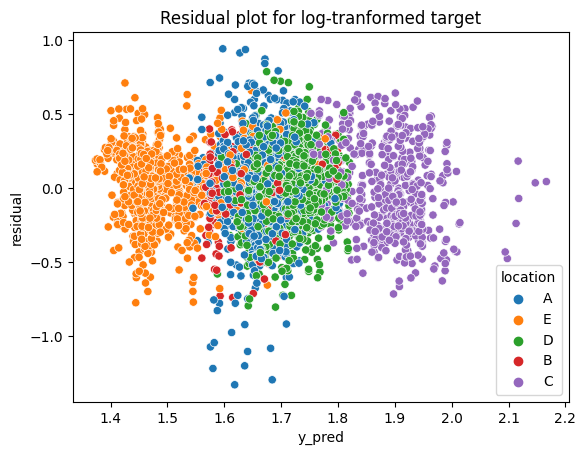

In [64]:
sns.scatterplot(x=y_pred_log, y=residual_log, hue=X_test['location'])
plt.xlabel('y_pred')
plt.ylabel('residual')
plt.title('Residual plot for log-tranformed target');

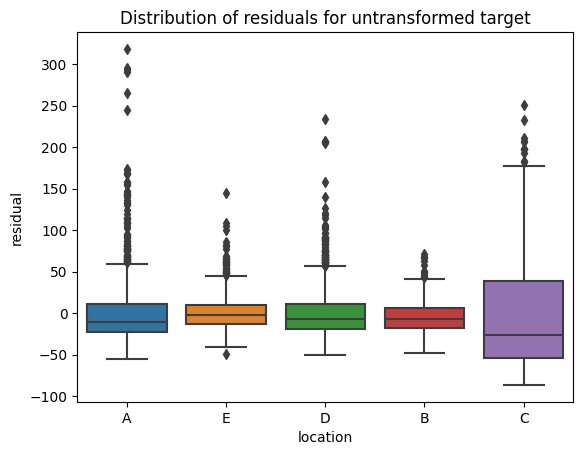

In [67]:
sns.boxplot(y=residual, x=X_test['location'])
plt.title('Distribution of residuals for untransformed target')
plt.ylabel('residual');

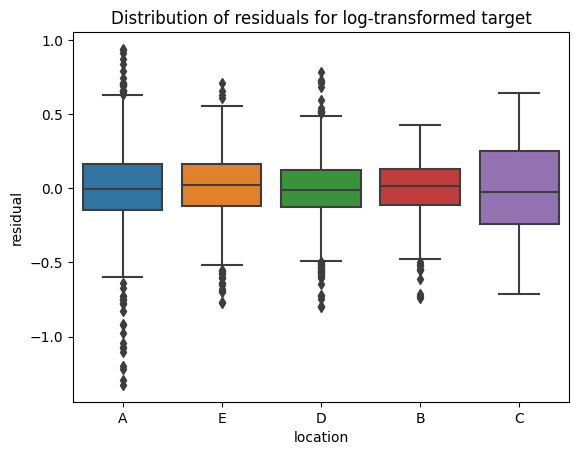

In [68]:
sns.boxplot(y=residual_log, x=X_test['location'])
plt.title('Distribution of residuals for log-transformed target')
plt.ylabel('residual');

### Conclusion
Using the dummy-encoded sensor locations as another feature for predicting our target strongly improved our prediction accuracy. For our improved model, the RMSE is 39.05 and R^2 is 0.18. By contrast, for our baseline model, RMSE was 41.11 and R^2 was 0.09.

Also, log-transforming the target variable further improved the R^2 score to 0.20.

**Possible steps to improve prediction accuracy**
1) Standardize features within each sensor location to avoid cofounds by variables specific to sensor locations
2) Perform hierarchical linear modeling
3) Test different sets of features and/or different types of ML algorithms